# <center>Mobile Games: A/B Testing & Player Retention </center>

## Table of Contents

1. **[Project Background](#1)**
2. **[About the Data](#2)**
3. **[Analyzing Player Behavior ](#3)**
4. **[Comparing 1-day Retention](#4)**
5. **[Comparing 7-day Retention](#5)**
6. **[Conclusion](#6)**

## Part 1. Project Background <a name= '1'></a>

<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will <strong>occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress</strong>. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.<p>But where should the gates be placed? Initially the first gate was placed at level 30. <strong>In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.</strong> </p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

## Part 2. About the Data  <a name= '2'></a>

### 2.1 Load the AB-test data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_excel('cookie_cats.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after install
<li><code>retention_1</code> - did the player come back and play 1 day after SEE THE GATE?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after SEE THE GATE?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

In [2]:
# version = 玩家看到Gate是出現在第30關, 還是第40關
# sum_gamerounds = 自從玩家下載了遊戲之後的第一週,一共玩了多少關卡
# retention_1 = 自從玩家看到了不論是第30關的Gate 還是第40關的Gate, 玩家在“當天”是否retend？
# retention_7 = 自從玩家看到了不論是第30關的Gate 還是第40關的Gate, 7天以後, 玩家是否有繼續玩？


### 2.2 Check missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Luckily, there is no missing value in this dataset.
### 2.3 Count the number of players in each group

In [4]:
# 分成control group和 treatment group, 並計算各組分別有多少user
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<p>When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The number of players is roughly the same in the control and test group, nice!

## Part 3. Analyzing Player Behavior  <a name= '3'></a>

We will plot a boxplot to visualize the distribution of 'sum_gamerounds', which would give us a rough idea of how many game rounds were played by a player during the first week after installing the game.

<Axes: >

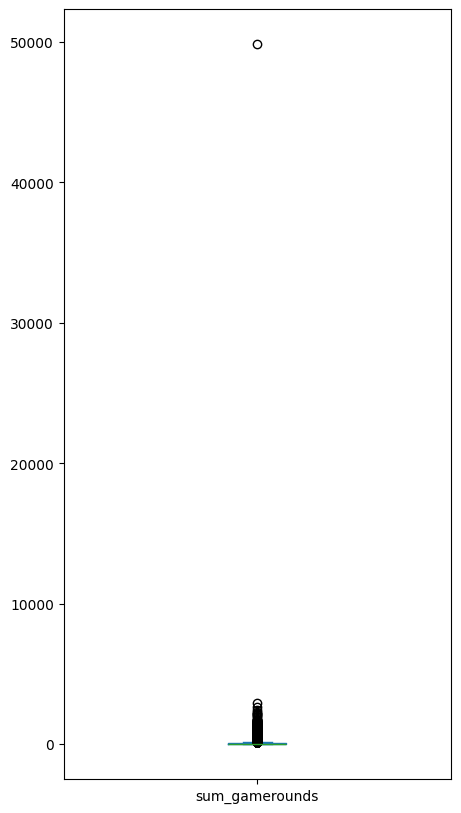

In [5]:
# 做EDA,觀察”自從下載遊戲後的第一週“數據.大部分人玩到5000關
# 發現第一週有個人“第一週玩到第五萬關”
# 懷疑到底合不合理. 合理就保留,不合理就當作異常值

df['sum_gamerounds'].plot.box(figsize=(5,10))

Clearly, there is an outlier. This player played about 50,000 game rounds during the first week! Due to this outlier, this boxplot is extremely skewed and not very informative. To learn about the behavior of the majority of the players, we will check the percentiles.

In [6]:
df['sum_gamerounds'].describe()

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


In [7]:
# 平均值mean : 51關. 標準差：195關. 代表分佈比較偏態Skew, 因為最大值是49000關

In [8]:
# Counting the number of players for each number of gamerounds
# 計算每一關有多少玩家
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2294,1
2438,1
2640,1


<p>As we can see, 50% of players played fewer than 16 game rounds during the first week after installation, and 75% of players played fewer than 51 rounds.
<p>Nearly 4000 players did not even play a single round after installation. Possible reasons may include:
<ul>
    <li>They downloaded a number of new games at the same time and were attracted by other games.
    <li>They opened the app but did not like the design/interface/music, so they quit even before playing the game.
    <li>They have not started playing the game yet.
    <li>......
</ul>

<p>Another number worth attention is that more than 14,000 players played fewer than three rounds. For these players, the reasons for leaving may include: </p>
<ul>
    <li>They did not enjoy the game. (This is probably the most common reason).
    <li>The game turned out to be different from what they expected.
    <li>The game was too easy and they got bored of it.
    <li>......
</ul>

It is important to understand why a large number of players quit the game at an early stage. Tactile Entertainment can try to collect player feedback, for example, through an in-app survey.

Text(0.5, 0, '# Game rounds')

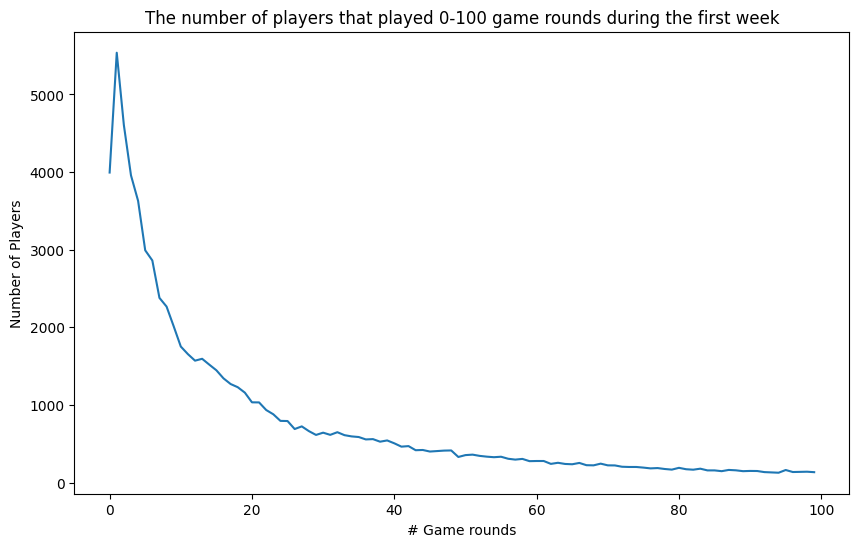

In [9]:
# Plot the distribution of players that played 0 to 100 game rounds during their first week playing the game.
# 把“第一週”玩第一到第一百關卡玩家人數的分佈畫出來. 1-100的關卡對應著玩家人數
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

# 右偏, 平均值 > 中位數

The distribution is highly skewed, with a long tail on the right. A huge number of players played fewer than 20 rounds and left the game. For rounds greater than 60, the number of players stayed steady at about 300.

## Part 4. Comparing 1-day Retention  <a name= '4'></a>

<p>In the plot above we can see that some players install the game but then never play it, some players just play a couple of game rounds in their first week, and some get really hooked! What we want is for players to like the game and to get hooked.
<p>A common metric in the video gaming industry for how fun and engaging a game is <strong>1-day retention: the percentage of players that comes back and plays the game one day after they have installed it.</strong>  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>

#### *Overall 1-day retention*

In [10]:
#計算retention_1的留存率是多少 比如用sum/count 就是留存率

df['retention_1'].sum() / df['retention_1'].count() # When using .sum(), T/F will first be converted to 1/0.

# Equivalent to df['retention_1'].mean()
# Mean is calculated by summing the values and dividing by the total number of values.

np.float64(0.4452095044850259)

A little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

#### *1-day retention for each AB-group*

In [11]:
# groupby control group & teatment group. 這裡是用version版本的不同
df.groupby('version')['retention_1'].mean()

,retention_1
version,
gate_30,0.448188
gate_40,0.442283


In [12]:
# 這只是樣本(觀察)的結論
# 發現gate_30的留存率比gate_40的留存率高,但不能肯定總體也是相同的結論.
# 如何把樣本結論映射到總體結論裡？ 若不用假設檢驗,就用Bootstrapping的方法去映射總體結論

It appears that <strong>there was a slight decrease in 1-day retention when the gate was moved to level 40</strong> (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?
<p>There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

#### *Bootstrapping: Should we be confident in the difference?*

In [13]:
# Bootstrapping Method：有放回的隨機重抽樣(re-sample with replacement)
# 每抽一次都有gate_30和gate_40的 1-day return rate 結果(也就是一對).抽完再放回去. 再抽
# 重複抽1000次 = 隨機抽出 1000對的 "gate_30 和 gate_40 1-day return rate"

# 這就是在模擬總體Poplution 1-day return rate gate_30和 gate_40的分佈, 觀察能否映射到Population裡面

In [14]:
# Bootstrapping Method
# 1. 建立Bootstrap Sample

# df.sample():從df中進行抽樣
# frac=1: 代表要抽出和原始數量一樣多的樣本數
# replace=True: 有放回的抽樣(可抽到重複的樣本)

df.sample(frac = 1,replace = True)

,userid,version,sum_gamerounds,retention_1,retention_7
27992,3118628,gate_30,63,True,True
70314,7796541,gate_30,0,False,False
31151,3467355,gate_40,109,True,False
42614,4714291,gate_40,2,False,False
34824,3856395,gate_30,2,False,False
...,...,...,...,...,...
61537,6818785,gate_30,2,False,False
22240,2477892,gate_30,3,False,False
20461,2274495,gate_30,13,False,False
23289,2593463,gate_40,36,True,False


In [15]:
# 從df中做有放回的抽樣, 會得到Bootstrap 的Dataset
# 根據'version'來分組
# 對每組計算retention_1的平均 = 計算每組的轉換率


df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()

,retention_1
version,
gate_30,0.448601
gate_40,0.440727


Text(0.5, 1.0, 'Bootstrapped distribution of 1-day retention')

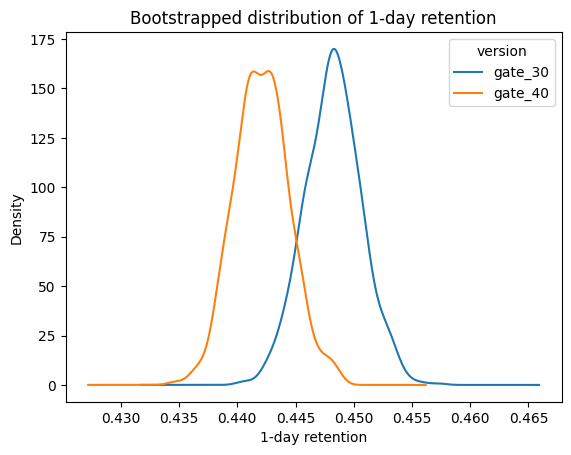

In [16]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = [] # 空列表
for i in range(1000): #循環一千次
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
# Sample with replacement有放回的隨機抽樣.抽出的這部分,照著gate_30和40的1-day retention rate
# 把每次抽出來的gate_30和40的1-day retention rate 存進boot_mean這個variable裡
# 再把它append到空的列表裡.循環一千次,每次都會存進這個空列表裡. 這個空列表裡有一千對的gate_30和40的1-day retention rate

# Transforming the list to a DataFrame
# 放進DataFrame裡,變成兩列一千行
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')
plt.xlabel('1-day retention')
plt.title('Bootstrapped distribution of 1-day retention')

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. There seems to be some evidence of a difference, albeit small. Let's plot the % difference to have a closer look.

In [17]:
# 到底這一千對裡,有多少是gate_30比gate_40的1-day retention rate 還要高呢?

In [18]:
# 相對差異(relative difference)的計算方式

# (舊版本gate_30-新版本gate_40) / 除以新版本 gate_40
# 除以新版本gate_40的原因：想知道舊版本比新版本低了多少比例？ = 如果使用新版本gate_40,相較於原本的舊版本gate_30提升了多少？

Probability that 1-day retention is greater when the gate is at level 30: 0.961


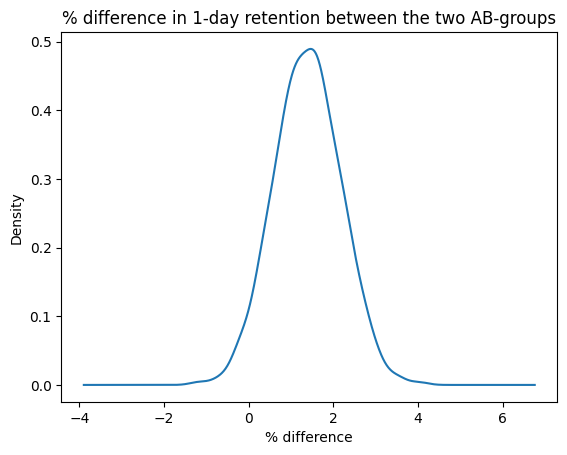

In [19]:
# Adding a column with the % difference between the two AB-groups
# 具體gate_30比gate_40多多少的機率(=difference)？ “使用新版本gate_40,相較於原本的舊版本gate_30提升了多少？”
# 把gate_30的1-day retention rate - gate_40的1-day retention rate. 把一千個difference都做這樣的差

# 重點：這一行在計算 “舊版本的結果跟新版本相比, 差多少個百分比”. 所以是站在新版本的角度來看差異
# 所以除以gate_40是以gate_40為基準的角度去分析

boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')
plt.xlabel('% difference') #x軸是具體gate_30比gate_40多多少的機率(=difference), y軸是出現的頻率.

# 0 就是gate_30=gate_40的情況. 這個分佈圖的右邊都是gate_30比gate_40好的情況
# 那要如何算右邊的面積？有多少是 gate_30 - gate_40 大於0的情況.把一千個difference去和0做判斷.問他是否大於0？
# 只要大於0, return True. 那True/False自動返回1/0. 那1/0的平均值就是Probability.

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

# 一千對裡有970對都是gate_30 - gate_40 大於0的情況. (gate_30較好的情況) = 97%都是gate_30 比gate_40好的情況

From this chart, we can see that the most likely % difference is around 1% - 2%, and that <strong>96% of the distribution is above 0%, in favor of a gate at level 30. </strong>

## Part 5. Comparing 7-day Retention  <a name= '5'></a>
The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. <p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention.

In [20]:
df.groupby('version')['retention_7'].mean()

,retention_7
version,
gate_30,0.190201
gate_40,0.182000


**Insights:**
<ul>
    <li><strong>Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40</strong> (18.2%) than when the gate is at level 30 (19.0%).
    <li><strong>This difference is also larger than for 1-day retention</strong>, presumably because more players have had time to hit the first gate.
    <li> <strong>The overall 7-day retention is lower than the overall 1-day retention</strong>; fewer people play a game a week after installing than a day after installing.
</ul>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

Probability that 7-day retention is greater when the gate is at level 30: 1.0


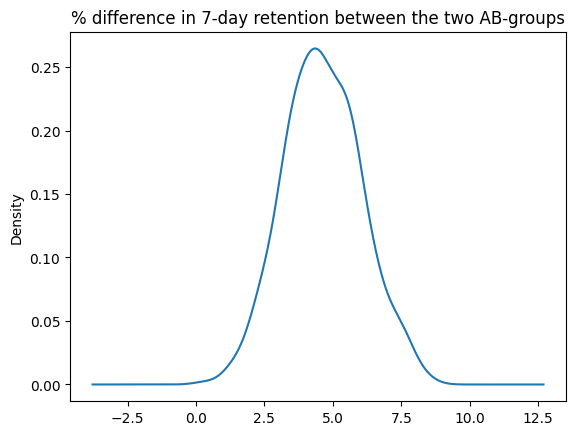

In [21]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

## Part 6. Conclusion  <a name= '6'></a>
<p>The bootstrap result tells us that <strong>there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.</strong> The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.
<p>There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>


<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this.
<p>In short, <strong>hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously.</strong> By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But <strong>when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </strong></p>

# bonus point = eda- correlation + 3 method -> draw similar conclusion

## Bonus #1: EDA - correlation
* 做一個eda圖. 顯示sum_gamerounds, retention_1, retention_7的相關性.
* 觀察會不會有些人玩的關數多又容易retend？
* 1. 把這三列選出來(sum_gamerounds, retention_1, retention_7).corr結合heatmap
* 2. 把每一個人標上一個label. T/T, T/F, F/T, F/F 這四種狀況各自標上一個label.
* 3. 對於這四個label,看sum_gamerounds的分佈.x軸放這四個label, y軸放sum_gamerounds的分佈(畫boxplot), hue = control group 和 treatment group, 用bins畫出四個label的分佈

In [22]:
df_corr = df[['sum_gamerounds','retention_1','retention_7']].corr()

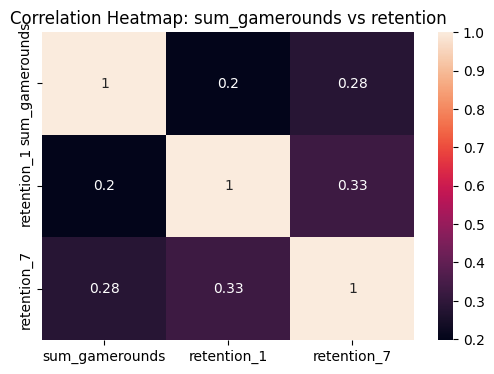

In [23]:
plt.figure(figsize = (6,4))
sns.heatmap(df_corr, annot = True)
plt.title("Correlation Heatmap: sum_gamerounds vs retention")
plt.show()

In [24]:
# 建立label的列(根據retention_1和retention_7)
# 用apply(row)搭配 axis=1. 代表要對dataframe中的每一row做處理,並根據每一列的retention_1和retention_7 決定它的 類別label
# 如果retention_1 ==True, 就用'T',否則'F'
# 如果retention_7 ==True, 就用'T',否則'F', 這兩句用／隔開
# 再把這一整段儲存在新的列,叫做'label'裡

df['label'] = df.apply(lambda row:
                       f"{'T' if row['retention_1'] else 'F'}/{'T' if row['retention_7'] else 'F'}",
                       axis=1)

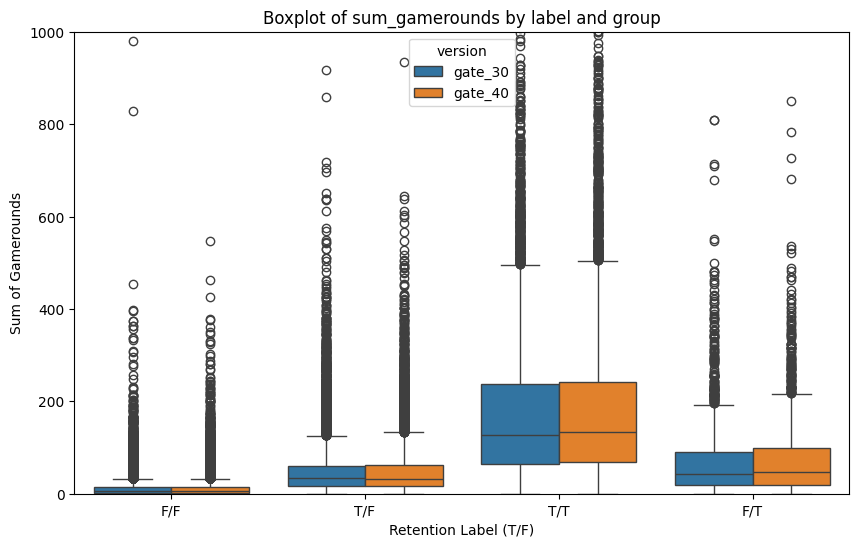

In [25]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'label', y = 'sum_gamerounds', data = df, hue = 'version')
plt.ylim(0,1000)
plt.title("Boxplot of sum_gamerounds by label and group")
plt.xlabel("Retention Label (T/F)")
plt.ylabel("Sum of Gamerounds")
plt.show()

## Bonus #2-1 : 1-day retention rate

* (1) Z-test 套公式 ＋ 調包
* (2) T-test 套公式 ＋ 調包
* (3) Bootstrapping

###(1) Z-test 套公式 ＋ 調包

In [26]:
# 計算retention_1的留存率是多少

df['retention_1'].sum() / df['retention_1'].count()

# 1-day retention rate for each AB group

df.groupby('version')['retention_1'].mean()

,retention_1
version,
gate_30,0.448188
gate_40,0.442283


In [27]:
# 這只是樣本(觀察)的結論
# 發現gate_30的留存率比gate_40的留存率高,但不能肯定總體也是相同的結論.

1. 理解要計算的指標：retention_1

* df['retention_1'] 是一個 0 或 1 的欄位（1 = 使用者隔天有回來）
* 所以可以用 .sum() 來看有幾個人回來
* .count() 看的是這個 group 裡總共有幾個人

2. 定義要套入公式的四個數值

* convert_old = 舊版本（control）中，有回來的總人數(轉換人數)
* convert_new = 新版本（treatment）中，有回來的總人數(轉換人數)
* n_old = 舊版本中總人數（分母）
* n_new = 新版本中總人數（分母）

In [28]:
# 3. 轉換成功的數量(1-day retention 為 1 的人數)

convert_old = df[df['version'] == 'gate_30']['retention_1'].sum() # 舊版本中，在第一天有回來的使用者人數
convert_new = df[df['version'] == 'gate_40']['retention_1'].sum() # 新版本中，在第一天有回來的使用者人數

# 計算樣本人數

n_old = df[df['version'] == 'gate_30']['retention_1'].count()
n_new = df[df['version'] == 'gate_40']['retention_1'].count()


In [29]:
# 4. 計算轉換率（p1, p0）＋ Z 值

# 轉換率（= 有回來的人 / 總人數）

p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [30]:
# Method 1. 1-day retention rate Z - Test 套公式

def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

In [31]:
# 計算 Z 值

z_value = z_test(p1,p0,n1,n0)
z_value

np.float64(-1.7840862247974725)

In [32]:
# 5. 計算 p-value
# 通過查表 或 scipy.stats函數, 得出p-value

from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

# Method1. 套公式結論
print("Z-test:", z_value)
print("P-value:", p_value)

# 比較p-value 和 alpha
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Z-test: -1.7840862247974725
P-value: 0.9627951723515404
Fail to reject null hypothesis


In [33]:
# Method 2. 1-day retention rate Z - Test 調包
import statsmodels.api as sm

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

# Method 2. 調包結論

print("Z-test:", z_score)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Z-test: -1.7840862247974725
P-value: 0.9627951723515404
Fail to reject null hypothesis


### (2) T-test 套公式 ＋ 調包

1. T-test 檢定目的：
* 比較 gate_30 vs gate_40 兩組「樣本的平均值」是否顯著不同
* 這個平均值仍是 retention_1，所以是 binary 值的平均，代表轉換率

2. 定義要套入公式的四個數值
* 只需要每組的平均和樣本數

* po = gate_30 的轉換率 = retention_1的平均值
* p1 = gate_40 的轉換率 = retention_1的平均值

* no = gate_30 的樣本數
* n1 = gate_40 的樣本數

In [35]:
# 每組rentention_1 平均值

p1 = df[df['version'] == 'gate_40']['retention_1'].mean()
p0 = df[df['version'] == 'gate_30']['retention_1'].mean()

# 每組樣本數

n1 = df[df['version'] == 'gate_40']['retention_1'].count()
n0 = df[df['version'] == 'gate_30']['retention_1'].count()

In [36]:
# Method 1: 套用公式算出t-value和p-value的步驟 (手動計算Ｔ-test)

def t_test(p1, p0, n1, n0):
    # 各組的樣本變異數（Bernoulli 分布的近似變異數）
    s1_squared = p1 * (1 - p1)
    s0_squared = p0 * (1 - p0)

    # t 值計算
    delta = p1 - p0
    se = np.sqrt(s1_squared / n1 + s0_squared / n0)
    return delta / se

In [37]:
# 得出t_value 和 p_value

t_value = t_test(p1, p0, n1, n0)
print("T-value:", t_value)

from scipy.stats import t
p_value = 1 - t.cdf(t_value, df=n1+n0-2)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

T-value: -1.7840972718297632
P-value: 0.9627943892602068
Fail to reject null hypothesis


In [38]:
# Method 2. T-test 調包

from statsmodels.stats.weightstats import ttest_ind

In [39]:
# 1. 傳入整組 retention_1 資料（每筆都是 0 或 1）

retention_30 = df[df['version'] == 'gate_30']['retention_1']
retention_40 = df[df['version'] == 'gate_40']['retention_1']

# 2. 計算 t-test（alternative='larger' 是單尾檢定：gate_40 > gate_30）
t_stat, p_value, dfree = ttest_ind(retention_40, retention_30, alternative='larger')


# Method 2. 調包結論

print("T-value:", t_stat)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")


T-value: -1.7840979256519554
P-value: 0.9627944423721833
Fail to reject null hypothesis


### (3) Bootstrapping

Probability that 1-day retention is greater when the gate is at level 30: 0.961


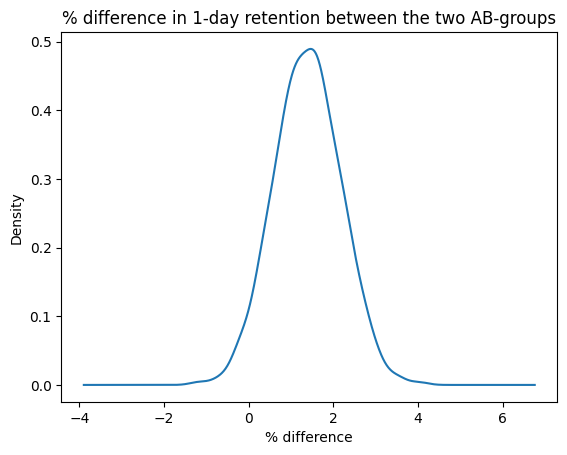

In [40]:
# Adding a column with the % difference between the two AB-groups
# 具體gate_30比gate_40多多少的機率(=difference)？ “使用新版本gate_40,相較於原本的舊版本gate_30提升了多少？”
# 把gate_30的1-day retention rate - gate_40的1-day retention rate. 把一千個difference都做這樣的差

# 重點：這一行在計算 “舊版本的結果跟新版本相比, 差多少個百分比”. 所以是站在新版本的角度來看差異
# 所以除以gate_40是以gate_40為基準的角度去分析

boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')
plt.xlabel('% difference') #x軸是具體gate_30比gate_40多多少的機率(=difference), y軸是出現的頻率.

# 0 就是gate_30=gate_40的情況. 這個分佈圖的右邊都是gate_30比gate_40好的情況
# 那要如何算右邊的面積？有多少是 gate_30 - gate_40 大於0的情況.把一千個difference去和0做判斷.問他是否大於0？
# 只要大於0, return True. 那True/False自動返回1/0. 那1/0的平均值就是Probability.

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

# 一千對裡有970對都是gate_30 - gate_40 大於0的情況. (gate_30較好的情況) = 97%都是gate_30 比gate_40好的情況

## Bonus #2-2 : 7-day retention rate

* (1) Z-test 套公式 ＋ 調包
* (2) T-test 套公式 ＋ 調包
* (3) Bootstrapping

### (1) Z-test 套公式 ＋ 調包

In [41]:
# 3. 轉換成功的數量(7-day retention 為 1 的人數)

convert_old = df[df['version'] == 'gate_30']['retention_7'].sum() # 舊版本中，在第一天有回來的使用者人數
convert_new = df[df['version'] == 'gate_40']['retention_7'].sum() # 新版本中，在第一天有回來的使用者人數

# 計算樣本人數

n_old = df[df['version'] == 'gate_30']['retention_7'].count()
n_new = df[df['version'] == 'gate_40']['retention_7'].count()

In [42]:
# 4. 計算轉換率（p1, p0）＋ Z 值

# 轉換率（= 有回來的人 / 總人數）

p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [43]:
# Method 1. 1-day retention rate Z - Test 套公式

def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

# 計算 Z 值

z_value = z_test(p1,p0,n1,n0)

# 計算 p-value
# 通過查表 或 scipy.stats函數, 得出p-value

from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

# Method1. 套公式結論
print("Z-test:", z_value)
print("P-value:", p_value)

# 比較p-value 和 alpha
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")


Z-test: -3.164358912748191
P-value: 0.9992228750121929
Fail to reject null hypothesis


In [44]:
# Method 2. 1-day retention rate Z - Test 調包
import statsmodels.api as sm

In [45]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

# Method 2. 調包結論

print("Z-test:", z_score)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Z-test: -3.164358912748191
P-value: 0.9992228750121929
Fail to reject null hypothesis


### (2) T-test 套公式 ＋ 調包

In [46]:
# 每組rentention_1 平均值

p1 = df[df['version'] == 'gate_40']['retention_7'].mean()
p0 = df[df['version'] == 'gate_30']['retention_7'].mean()

# 每組樣本數

n1 = df[df['version'] == 'gate_40']['retention_7'].count()
n0 = df[df['version'] == 'gate_30']['retention_7'].count()

In [47]:
# Method 1: 套用公式算出t-value和p-value的步驟 (手動計算Ｔ-test)

def t_test(p1, p0, n1, n0):
    # 各組的樣本變異數（Bernoulli 分布的近似變異數）
    s1_squared = p1 * (1 - p1)
    s0_squared = p0 * (1 - p0)

    # t 值計算
    delta = p1 - p0
    se = np.sqrt(s1_squared / n1 + s0_squared / n0)
    return delta / se

In [48]:
# 得出t_value 和 p_value

t_value = t_test(p1, p0, n1, n0)
print("T-value:", t_value)

from scipy.stats import t
p_value = 1 - t.cdf(t_value, df=n1+n0-2)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

T-value: -3.1640640401490985
P-value: 0.9992218290437873
Fail to reject null hypothesis


In [49]:
# Method 2. T-test 調包

from statsmodels.stats.weightstats import ttest_ind

In [50]:
# 1. 傳入整組 retention_7 資料（每筆都是 0 或 1）

retention_30 = df[df['version'] == 'gate_30']['retention_7']
retention_40 = df[df['version'] == 'gate_40']['retention_7']

# 2. 計算 t-test（alternative='larger' 是單尾檢定：gate_40 > gate_30）
t_stat, p_value, dfree = ttest_ind(retention_40, retention_30, alternative='larger')


# Method 2. 調包結論

print("T-value:", t_stat)
print("P-value:", p_value)

# 比較p-value 和 alpha

if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

T-value: -3.164499499680265
P-value: 0.9992229924399456
Fail to reject null hypothesis


### (3) Bootstapping

Probability that 7-day retention is greater when the gate is at level 30: 1.0


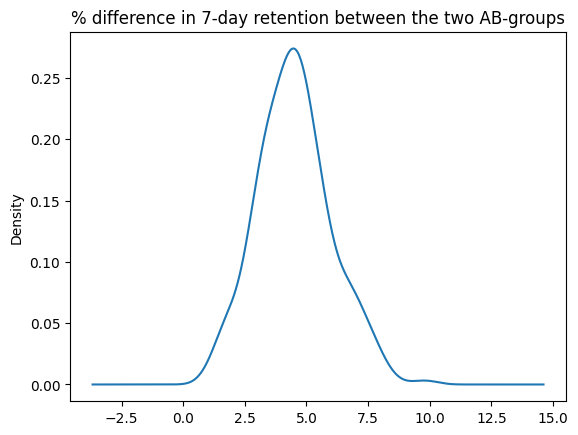

In [51]:
# 具體gate_30比gate_40多多少的機率(=difference)？ “使用新版本gate_40,相較於原本的舊版本gate_30提升了多少？”
# 把gate_30的1-day retention rate - gate_40的1-day retention rate. 把一千個difference都做這樣的差

# 重點：這一行在計算 “舊版本的結果跟新版本相比, 差多少個百分比”. 所以是站在新版本的角度來看差異
# 所以除以gate_40是以gate_40為基準的角度去分析

boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)


boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

# 0 就是gate_30=gate_40的情況. 這個分佈圖的右邊都是gate_30比gate_40好的情況
# 那要如何算右邊的面積？有多少是 gate_30 - gate_40 大於0的情況.把一千個difference去和0做判斷.問他是否大於0？
# 只要大於0, return True. 那True/False自動返回1/0. 那1/0的平均值就是Probability.
# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

# 一千對裡有970對都是gate_30 - gate_40 大於0的情況. (gate_30較好的情況) = 97%都是gate_30 比gate_40好的情況